In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
MODEL_PATH = os.path.join(PROJECT_PATH, '/my_human_pose/models')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

### Data 불러오고 구성 요소 살펴보기

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


`joints_vis` : 실제로 사용할 수 있는 keypoint인지 나타낸다. 1(visible) / 0(non)  
`joints` : keypoint의 label  
`scale` : 사람의 크기 비율 (200을 곱해야 온전한 크기가 된다. )  
`center` : 중심점  

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_sample = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(train_sample)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


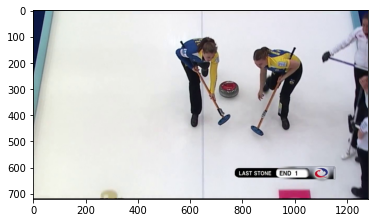

{'joints_vis': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'image': '015601864.jpg', 'scale': 3.021046, 'center': [594.0, 257.0]}


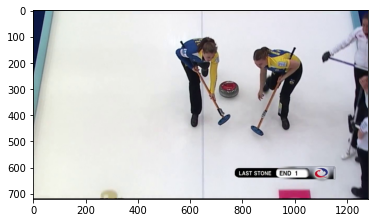

{'joints_vis': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[895.0, 293.0], [910.0, 279.0], [945.0, 223.0], [1012.0, 218.0], [961.0, 315.0], [960.0, 403.0], [979.0, 221.0], [906.0, 190.0], [912.4915, 190.6586], [830.5085, 182.3414], [871.0, 304.0], [883.0, 229.0], [888.0, 174.0], [924.0, 206.0], [1013.0, 203.0], [955.0, 263.0]], 'image': '015601864.jpg', 'scale': 2.472117, 'center': [952.0, 222.0]}


In [6]:
from skimage.io import imread
i = 0
img = train_annos[i]["image"]
img = imread(IMAGE_PATH + f"/{img}")
plt.imshow(img)
plt.show()
print(train_annos[i])
i = 1
img = train_annos[i]["image"]
img = imread(IMAGE_PATH + f"/{img}")
plt.imshow(img)
plt.show()
print(train_annos[i])

#### 한 이미지 내에 여러명의 사람이 있으면 어떻게 들어있을까?
한 이미지에 두명의 사람이 있다면 입력 데이터에 같은 이미지가 2번 들어있고 각각 한사람에 대한 정보가 들어있다.  
위 사진에서 본다면 두 이미지의 index는 다르지만 동일한 사진이 들어있다.  
또한 중심점 좌표로 보았을때 index0은 왼쪽 사람, index1은 오른쪽 사람인 것 같다.  

### TFRecord 파일 만들기  
데이터를 직렬화 한다.  
예를 들어, "서울 강동구에 사는 32살 고길동" -> "서울강동32고길동"  
다만 형식 고정 

In [43]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [44]:
def chunkify(l, n):
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

In [46]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

In [47]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

In [48]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2024-10-30 06:27:17,812	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.86gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

### TFRecord에 저장된 데이터 불러오기

In [2]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        # keypoint 중 유효한값(visible = 1) 만 사용합니다.
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        # min, max 값을 찾습니다.
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

### Step 1-1. simplebaseline 모델 완성하기

In [3]:
## joints 수만큼의 히트맵 
num_heatmap = 16

In [4]:
# resnet = tf.keras.applications.resnet.ResNet50(
#     include_top=False, 
#     weights='imagenet'
# )

In [5]:
def _make_deconv_layer(num_deconv_layers):
    seq_model = tf.keras.models.Sequential()
    for i in range(num_deconv_layers):
        seq_model.add(tf.keras.layers.Conv2DTranspose(256, kernel_size=(4,4), strides=(2,2), padding='same'))
        seq_model.add(tf.keras.layers.BatchNormalization())
        seq_model.add(tf.keras.layers.ReLU())
    return seq_model

In [6]:
def Simplebaseline(input_shape=(256, 256, 3), num_heatmap=16):
    inputs = tf.keras.Input(shape=input_shape)
    
    resnet = tf.keras.applications.resnet.ResNet50(
        include_top=False, 
        weights='imagenet'
    )
    x = resnet(inputs)
    x = _make_deconv_layer(3)(x)
    out = tf.keras.layers.Conv2D(num_heatmap, kernel_size=(1,1), padding='same')(x)

    model = tf.keras.Model(inputs, out, name='simple_baseline')
    return model

In [7]:
simplebaseline_model = Simplebaseline()
simplebaseline_model.summary()

Model: "simple_baseline"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
resnet50 (Functional)        (None, None, None, 2048)  23587712  
_________________________________________________________________
sequential (Sequential)      (None, 64, 64, 256)       10489600  
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 16)        4112      
Total params: 34,081,424
Trainable params: 34,026,768
Non-trainable params: 54,656
_________________________________________________________________


### Step 1-2. StackedHourglass 모델 완성하기

In [8]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [9]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

In [10]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

In [11]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

In [12]:
stackedhourglassnetwork_model = StackedHourglassNetwork()
stackedhourglassnetwork_model.summary()

Model: "stacked_hourglass"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 128, 128, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
re_lu_3 (ReLU)                  (None, 128, 128, 64) 0           batch_normalization_3[0][0]      
__________________________________________________________________________________

### Step 2-1. simplebaseline 모델 훈련하기

In [20]:
class Trainer(object):
    def __init__(self,
                 model_name,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        # 학습할 텐서플로우 모델을 저장합니다
        if model_name == "simple-baseline":
            self.model = Simplebaseline()
        elif model_name == "stacked-hourglass":
            self.model = StackedHourglassNetwork()
        else:
            raise ValueError("지원되지 않는 모델 이름입니다.")
        self.model_name = model_name
        # 전체 학습 에포크 수를 저장합니다.
        self.epochs = epochs
        # 분산 학습에 사용할 tf.distribute.Strategy 객체를 저장합니다.
        self.strategy = strategy
        # 전체 배치 크기를 저장합니다.
        self.global_batch_size = global_batch_size
        # 손실 함수로 MeanSquaredError를 정의
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE # 각 샘플에 대한 개별 손실 값을 유지
        )
        # 옵티마이저를 정의하고 초기 학습률로 설정합니다.
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate
        )
#         self.model = model
        # 현재 학습률을 저장합니다. 학습 중 감소할 수 있습니다.
        self.current_learning_rate = initial_learning_rate
        # 직전 에포크의 검증 손실을 저장합니다.
        self.last_val_loss = math.inf
        # 현재까지 가장 낮은 검증 손실을 저장하여 성능 향상 여부를 모니터링합니다.
        self.lowest_val_loss = math.inf
        # 조기 종료를 위한 patience 카운터를 초기화합니다.
        self.patience_count = 0
        # 학습률을 감소시키기 전의 최대 patience 설정입니다.
        self.max_patience = 10
        # 가장 좋은 성능을 기록한 모델 경로를 저장합니다.
        self.best_model = None

    def lr_decay(self):
        '''학습률을 조정하는 메서드입니다.
        patience가 max_patience에 도달하면 학습률을 10배 감소시키고 
        patience를 초기화합니다.
        '''
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        '''에포크별로 학습률을 감소시키는 메서드입니다. 
        특정 에포크(25, 50, 75)에서 학습률을 10배 감소시킵니다.
        '''
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        '''
        모델 출력과 실제 레이블을 비교하여 가중치를 적용한 손실을 계산합니다. 
        배치 크기에 따라 손실을 나누어 정규화합니다.
        '''
        loss = tf.constant(0.0, dtype=tf.float32)  # float32 타입으로 초기화
        labels = tf.cast(labels, dtype=tf.float32)  # labels를 float32로 변환
        
        for output in outputs:
            output = tf.cast(output, dtype=tf.float32)  # output을 float32로 변환
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss
    
    def distance_from_prob(self, y_true, y_pred):
        """Get keypoint distance from heatmap probability.
        from https://github.com/samson6460/tf2_pose_estimation/blob/master/metrics/distance_metrics.py
        """
        if isinstance(y_pred, list):
            y_pred = y_pred[0]
        height, width = y_pred.get_shape()[1:3]

        index_map_x = tf.range(width, dtype=y_true.dtype)
        index_map_x = tf.reshape(index_map_x, (1, 1, -1, 1))
        index_map_y = tf.range(height, dtype=y_true.dtype)
        index_map_y = tf.reshape(index_map_y, (1, -1, 1, 1))

        y_true_map_x = y_true*index_map_x
        y_true_map_y = y_true*index_map_y
        y_pred_map_x = y_pred*index_map_x
        y_pred_map_y = y_pred*index_map_y

        y_true_x = tf.reduce_sum(y_true_map_x, axis=(1, 2))
        y_true_y = tf.reduce_sum(y_true_map_y, axis=(1, 2))
        y_pred_x = tf.reduce_sum(y_pred_map_x, axis=(1, 2))
        y_pred_y = tf.reduce_sum(y_pred_map_y, axis=(1, 2))

        dist = tf.math.sqrt(
            (y_true_x - y_pred_x)**2 + (y_true_y - y_pred_y)**2)

        dist = tf.reduce_mean(dist, axis=-1)

        return dist

    def train_step(self, inputs):
        '''
        학습 단계에서 사용되는 함수입니다. GradientTape로 모델 출력을 추적하고, 
        손실에 따라 그래디언트를 계산 후 옵티마이저로 가중치를 업데이트합니다.
        '''
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)
            metric_dist = self.distance_from_prob(labels, outputs)

        grads = tape.gradient(
            target=loss, 
            sources=self.model.trainable_variables
        )
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables)
        )

        return loss, metric_dist

    def val_step(self, inputs):
        '''
        검증 단계에서 사용됩니다. 검증용 데이터에 대해 모델을 평가하여 손실을 
        계산합니다.
        '''
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        metric_dist = self.distance_from_prob(labels, outputs)

        return loss, metric_dist

    def run(self, train_dist_dataset, val_dist_dataset):
        '''
        전체 학습 프로세스를 관리합니다. 에포크별로 학습 및 검증을 수행하고 
        모델 성능이 향상될 때마다 모델을 저장합니다.
        '''
        @tf.function
        def distributed_train_epoch(dataset):
            '''
            학습 데이터셋을 분산 학습하며 에포크 단위로 반복합니다. 배치 손실을
            계산하고 출력합니다.
            '''
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            total_metric_dist = tf.constant(0.0, dtype=tf.float32)
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss, per_metric_dist = self.strategy.run(
                    self.train_step, 
                    args=(one_batch, )
                )
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_replica_loss, 
                    axis=None
                )
                batch_metric_dist = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_metric_dist, 
                    axis=None
                )
                
                total_loss += tf.cast(batch_loss, tf.float32)
                total_metric_dist += tf.reduce_mean(tf.cast(batch_metric_dist, tf.float32))
                num_train_batches += 1
                
                # 100번째 배치마다 출력
                if tf.equal(num_train_batches % 100, 0):
                    tf.print(
                        'Trained batch', num_train_batches, 
                        'batch loss', batch_loss, 
                        'epoch total loss', total_loss / num_train_batches,
                        'epoch reduce mean metric dist', tf.reduce_mean(tf.cast(batch_metric_dist, tf.float32))
                    )

            return total_loss, num_train_batches, total_metric_dist

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            total_metric_dist = tf.constant(0.0, dtype=tf.float32)           
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss, per_metric_dist = self.strategy.run(
                    self.val_step, 
                    args=(one_batch, )
                )
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_replica_loss, 
                    axis=None
                )
                batch_metric_dist = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, 
                    per_metric_dist, 
                    axis=None
                )
                # 100번째 배치마다 출력
                if tf.equal(num_val_batches % 100, 0):
                    tf.print(
                        'Validated batch', num_val_batches, 
                        'batch loss', batch_loss, 
                        'batch metric distance', batch_metric_dist
                    )
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += tf.cast(batch_loss, tf.float32)
                else:
                    num_val_batches -= 1
                
                total_metric_dist += tf.reduce_mean(tf.cast(batch_metric_dist, tf.float32))

            return total_loss, num_val_batches, total_metric_dist

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print(
                '#####    Start epoch {} with learning rate {}    #####'.format(
                    epoch, self.current_learning_rate
                )
            )
            train_total_loss, num_train_batches, train_total_metric_dist = distributed_train_epoch(train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            train_metric_dist = train_total_metric_dist / num_train_batches
            print(
                '##    Epoch {} train loss {} train metric dist {}'.format(
                    epoch, train_loss, train_metric_dist
                )
            )

            val_total_loss, num_val_batches, val_total_metric_dist = distributed_val_epoch(val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            val_metric_dist = val_total_metric_dist / num_val_batches
            print(
                '##    Epoch {} val loss {} val metrci dist {}'.format(
                    epoch, val_loss, val_metric_dist
                )
            )

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_nm = MODEL_PATH + f'/{self.model_name}-epoch-{epoch}-loss-{loss}.h5'
        self.model.save_weights(model_nm)
        self.best_model = model_nm
        print("##    Model {} saved.".format(model_nm))

In [14]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [15]:
def train(
    model_name, 
    epochs, 
    learning_rate, 
    batch_size, 
    train_tfrecords, 
    val_tfrecords, 
    num_heatmap=16
):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(val_dataset)
                
        trainer = Trainer(
            model_name,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate
        )

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [16]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

#### 에러가 발생했던 곳!!!
"scope 내에 모델을 불러오거나, 층을 쌓거나, 최적화를 하거나 해야합니다!!"라는 에러가 발생했었다. 알고보니 `resnet`을 불러오는 과정이 `Simplebaseline()` 내에 있지 않고 밖에 두어 발생했던 에러였다. 따라서 `Simplebaseline()` 함수 내에 `resnet`을 불러오는 함수를 넣어서 해결했습니다!!!

In [17]:
model_name = "simple-baseline"

best_simple_baseline_file = train(
    model_name, 
    epochs, 
    learning_rate,  
    batch_size, 
    train_tfrecords, 
    val_tfrecords
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:374: UserWarning: To make it possible to preserve tf.data options across serialization boundaries, their implementation has moved to be part of the TensorFlow graph. As a consequence, the options value is in general no longer known at graph construction time. Invoking this method in graph mode retains the legacy behavior of the original implementation, but note that the returned value might not reflect the actual value of the options.
  warnings.warn("To make it possible to preserve tf.data options across "


Start distributed traininng...
Trained batch 100 batch loss 5.55698729 epoch total loss 6.68588114 epoch reduce mean metric dist 82645.6875
Trained batch 200 batch loss 6.52502728 epoch total loss 6.54500723 epoch reduce mean metric dist 94149.6094
Trained batch 300 batch loss 6.1480341 epoch total loss 6.50462341 epoch reduce mean metric dist 85952.0703
Trained batch 400 batch loss 6.33214 epoch total loss 6.45757866 epoch reduce mean metric dist 78408.4844
Trained batch 500 batch loss 5.6872592 epoch total loss 6.4659214 epoch reduce mean metric dist 95885.0938
Trained batch 600 batch loss 6.67787552 epoch total loss 6.4566555 epoch reduce mean metric dist 80364.5078
Trained batch 700 batch loss 6.10756731 epoch total loss 6.45449352 epoch reduce mean metric dist 93293.25
Trained batch 800 batch loss 6.42764711 epoch total loss 6.43808794 epoch reduce mean metric dist 85083.7
Trained batch 900 batch loss 6.509758 epoch total loss 6.42815065 epoch reduce mean metric dist 87487.5781
Tr

### Step 2-2. StackedHourglass 모델 훈련하기

In [18]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

In [21]:
model_name = "stacked-hourglass"

best_stacked_hourglass_file = train(
    model_name, 
    epochs, 
    learning_rate,  
    batch_size, 
    train_tfrecords, 
    val_tfrecords
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
#####    Start epoch 1 with learning rate 0.0007    #####
Start distributed traininng...
Trained batch 100 batch loss 1.70337331 epoch total loss 1.85777187 epoch reduce mean metric dist 124565.734
Trained batch 200 batch loss 1.71469092 epoch total loss 1.76249969 epoch reduce mean metric dist 105887.148
Trained batch 300 batch loss 1.63160443 epoch total loss 1.70476568 epoch reduce mean metric dist 94384.6797
Trained batch 400 batch loss 1.6301806 epoch total loss 1.68264973 epoch reduce mean metric dist 87399.3906
Trained batch 500 batch loss 1.57552707 epoch total loss 1.65740693 epoch reduce mean metric dist 84544.5
Trained batch 600 batch loss 1.61296523 epoch total loss 1.64257777 epoch reduce mean metric dist 80927.3438
Trained batch 700 batch loss 1.65972853 epoch total loss 1.62743306 epoch reduce mean metric dist 80837.7
Trained batch 800 batch loss 1.4067

### Step 3-1. 두 모델 학습된 모델 불러오기

In [13]:
simplebaseline_model = Simplebaseline()
simplebaseline_model.load_weights("/my_human_pose/models/simple-baseline-epoch-2-loss-6.297118663787842.h5")

In [14]:
stackedhourglass_model = StackedHourglassNetwork()
stackedhourglass_model.load_weights("/my_human_pose/models/stacked-hourglass-epoch-4-loss-1.2069120407104492.h5")

### Step 3-2. 두 모델 추론 결과 비교하기

In [15]:
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [16]:
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [17]:
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [18]:
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [19]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

## SimpleBaseline 모델


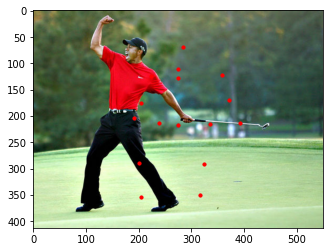

## StackedHourglass 모델


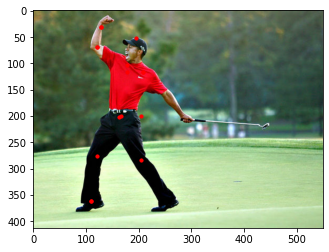

## SimpleBaseline 모델


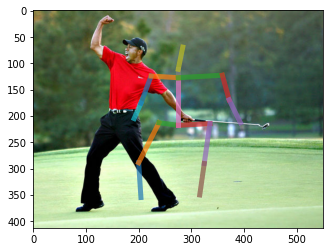

## StackedHourglass 모델


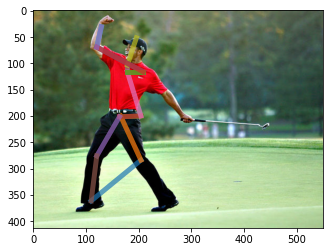

In [21]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

simplebaseline_image, simplebaseline_keypoints = predict(simplebaseline_model, test_image)
stackedhourglass_image, stackedhourglass_keypoints = predict(stackedhourglass_model, test_image)

print("## SimpleBaseline 모델")
draw_keypoints_on_image(simplebaseline_image, simplebaseline_keypoints)
print("## StackedHourglass 모델")
draw_keypoints_on_image(stackedhourglass_image, stackedhourglass_keypoints)

print("## SimpleBaseline 모델")
draw_skeleton_on_image(simplebaseline_image, simplebaseline_keypoints)
print("## StackedHourglass 모델")
draw_skeleton_on_image(stackedhourglass_image, stackedhourglass_keypoints)

#### 결과 비교
결과가 눈에 띄게 StackedHourglass 모델이 좋다.  
epoch이 2밖에 되지 않고 학습 결과도 비교해보지 못해서 최적화가 되었는지 확인할 수 없다.  
그치만 StackedHourglass 모델의 추론 시각화 결과는 좋아보인다.  

### Step 3-3. 두 모델 추론 속도 비교하기
는 못햇다....

### 회고
scope를 사용하면서 발생한 에러를 해결하는데 하루나 걸렸다..  
그래도 에러를 해결해서 다행이지만 다른 방법을 적용해보는 것에 집중하지 못했다.  
데이터 셋의 구성이 한 이미지에 한 사람의 중심점, 한 사람의 keypoint만 존재한다.  
이러한 데이터 셋으로 학습을 한다면 테스트 셋에 여러 사람이 존재할 때 찾아내지 못할 것이다.  